In [23]:
import pandas as pd
from servier.utils import describe_df
import numpy as np
PATH = '/Users/jeanbizot/Documents/projets/PERSO/servier/servier/data/'

In [24]:
file_path = PATH + 'dataset_single.csv'
file_path_multi = PATH + 'dataset_multi.csv'

In [25]:
df = pd.read_csv(file_path)
df2 = pd.read_csv(file_path_multi)

In [26]:
df.sample(10).smiles.values

array(['Cc1ccc2cc3cc(C(=O)NCc4ccc5c(c4)OCO5)oc3nc2c1',
       'CCSc1sc(CC)cc1C(=O)O',
       'Cc1ccc(Cn2c(SCCN3CCCCC3)nc3c2c(=O)n(C)c(=O)n3C)cc1',
       'COCCn1c(C)cc(C(=O)CSc2ncn[nH]2)c1C',
       'CC1C(=O)C(C)C(c2cccs2)NC1c1cccs1',
       'O=C(Cn1c(C(=O)N2CCc3ccccc3C2)cc2sccc21)c1ccccc1',
       'CN(C(=O)c1ccncc1)c1nnc(-c2ccccn2)s1',
       'C=CCOC(=O)C1=C(C)NC(SC)=C(C#N)C1c1cccs1',
       'CCOC(=O)c1c(-c2cccs2)csc1NC(=O)CSc1ncn[nH]1',
       'Cc1c(Cl)ccc(S(=O)(=O)N2CCN=C2c2ccccc2)c1Cl'], dtype=object)

# Rdkit exploration

In [27]:
from rdkit.Chem import rdMolDescriptors, MolFromSmiles, rdmolfiles, rdmolops, DataStructs

In [28]:
smile = "Cc1cccc(N2CCN(C(=O)C34CC5CC(CC(C5)C3)C4)CC2)c1C"

In [29]:
mol = MolFromSmiles(smile)
new_order = rdmolfiles.CanonicalRankAtoms(mol)

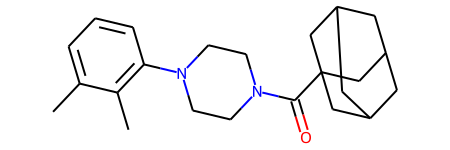

In [30]:
mol

In [31]:
list(new_order)

[0,
 17,
 4,
 3,
 5,
 18,
 24,
 11,
 9,
 23,
 16,
 2,
 25,
 14,
 21,
 6,
 20,
 7,
 22,
 8,
 15,
 13,
 10,
 12,
 19,
 1]

# Preprocessing

In [32]:
def fingerprint_features(smile_string, radius=2, size=2048):
    """
    :param smile_string:
    :param radius: no default value, usually set 2 for similarity search and 3 for machine learning
    :param size: (nBits) number of bits, default is 2048. 1024 is also widely used.
    :return:
    """
    mol = MolFromSmiles(smile_string)
    new_order = rdmolfiles.CanonicalRankAtoms(mol)
    mol = rdmolops.RenumberAtoms(mol, new_order)
    return list(rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=radius,
                                                          nBits=size,
                                                          useChirality=True,
                                                          useBondTypes=True,
                                                          useFeatures=False))

def df_to_features(df, col='smiles', radius=2, size=2048, *args, **kwargs):
    l_cols = [f'Bit_{i}' for i in range(size)]
    l_smiles = df[col].values
    vect_list = []
    for smile in l_smiles:
        fingerprint_vect = fingerprint_features(smile, radius=radius, size=size)
        vect_list.append(fingerprint_vect)
    df_morgan = pd.DataFrame(vect_list, columns=l_cols)
    df_final = pd.concat([df, df_morgan.astype('int8')], axis=1)
    return df_final

In [33]:
mol = "Cc1cccc(N2CCN(C(=O)C34CC5CC(CC(C5)C3)C4)CC2)c1C"

In [63]:
%%time
SIZE = 1024
df_final = df_to_features(df, radius=3, size=SIZE)

CPU times: user 4.76 s, sys: 70.1 ms, total: 4.83 s
Wall time: 4.84 s


In [64]:
df_final.head()

,P1,mol_id,smiles,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,...,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
0,1,CID2999678,Cc1cccc(N2CCN(C(=O)C34CC5CC(CC(C5)C3)C4)CC2)c1C,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,CID2999679,Cn1ccnc1SCC(=O)Nc1ccc(Oc2ccccc2)cc1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,CID2999672,COc1cc2c(cc1NC(=O)CN1C(=O)NC3(CCc4ccccc43)C1=O...,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,CID5390002,O=C1/C(=C/NC2CCS(=O)(=O)C2)c2ccccc2C(=O)N1c1cc...,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
4,1,CID2999670,NC(=O)NC(Cc1ccccc1)C(=O)O,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Training

In [41]:
#import keras as k
from keras.models import Sequential
from keras.layers import Activation, BatchNormalization, Dropout
from keras.layers.core import Dense
from keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from sklearn.model_selection import train_test_split

def get_class_weights(y):
    (unique, counts) = np.unique(y, return_counts=True)
    d = {}
    for k,v in zip(unique, counts):
        d[k] = round(v/len(y), 2)
    return d

In [42]:
X = df_final.filter(regex='Bit').values
y = df_final.P1.values
w = get_class_weights(y)

In [43]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.15)

In [55]:
"""NEURAL NETWORK"""
#The neural network model
def get_model(size, verbose=False):
    model = Sequential([
        Dense(size, input_shape=(size,), activation="relu"),
        Dropout(0.2),
        Dense(512, activation="sigmoid"),
        Dropout(0.2),
        Dense(128, activation="sigmoid"),
        Dropout(0.2),
        Dense(16, activation="sigmoid"),
        BatchNormalization(axis=1),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(lr=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [56]:
#Compiling the model
from keras.wrappers.scikit_learn import KerasClassifier
model = KerasClassifier(get_model, size=SIZE, batch_size=10, epochs=10, shuffle=True, class_weight=w,
                                    verbose=1, validation_data=(X_val, y_val))

In [57]:
%%time
#Training the model
model.fit(X_train, y_train)

Epoch 1/10
425/425 [==============================] - 2s 5ms/step - loss: 0.5136 - accuracy: 0.5382 - val_loss: 0.6260 - val_accuracy: 0.8213
Epoch 2/10
425/425 [==============================] - 2s 4ms/step - loss: 0.4020 - accuracy: 0.6776 - val_loss: 0.5572 - val_accuracy: 0.8267
Epoch 3/10
425/425 [==============================] - 2s 4ms/step - loss: 0.3358 - accuracy: 0.7849 - val_loss: 0.4973 - val_accuracy: 0.8213
Epoch 4/10
425/425 [==============================] - 2s 4ms/step - loss: 0.2811 - accuracy: 0.8200 - val_loss: 0.4691 - val_accuracy: 0.8253
Epoch 5/10
425/425 [==============================] - 2s 4ms/step - loss: 0.2331 - accuracy: 0.8261 - val_loss: 0.4559 - val_accuracy: 0.8267
Epoch 6/10
425/425 [==============================] - 2s 6ms/step - loss: 0.1943 - accuracy: 0.8383 - val_loss: 0.4411 - val_accuracy: 0.8253
Epoch 7/10
425/425 [==============================] - 2s 5ms/step - loss: 0.1606 - accuracy: 0.8466 - val_loss: 0.4456 - val_accuracy: 0.8173
Epoch 

# Prediction

In [58]:
#Predictions with test dataset
y_pred = model.predict(X_val, batch_size=1, verbose=1)

750/750 [==============================] - 1s 798us/step


# Evaluation

In [60]:
import copy
import matplotlib.pyplot as plt
from servier.utils import perf_eval_classif

def plot_confusion_wiki(confmat):
    fig, ax = plt.subplots(figsize=(5, 5))
    confmat_wiki = copy.copy(confmat.T)
    confmat_wiki[0][0] = confmat[1][1]
    confmat_wiki[1][1] = confmat[0][0]
    ax.matshow(confmat_wiki, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat_wiki.shape[0]):
        for j in range(confmat_wiki.shape[1]):
            ax.text(x=j, y=i, s=confmat_wiki[i, j], va='center', ha='center')
    ax.set_xticklabels([0, 1])
    ax.set_yticklabels([0, 1])
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.tight_layout()

In [61]:

perf_eval = perf_eval_classif(y_val, y_pred, verbose=False)

/Users/jeanbizot/miniconda3/envs/servier/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]
/Users/jeanbizot/miniconda3/envs/servier/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


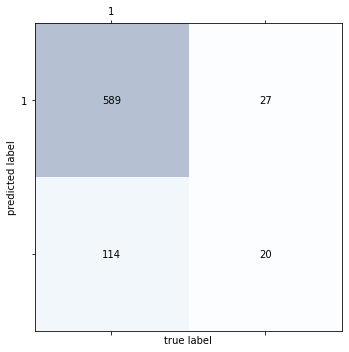

In [62]:
plot_confusion_wiki(perf_eval['confusion_matrix'])

In [171]:
perf_eval

{'f1': 0.8050632911392406,
 'ROC': 0.5438917425857724,
 'precision': 0.8383128295254832,
 'recall': 0.7743506493506493,
 'confusion_matrix': array([[ 42,  92],
        [139, 477]])}

# Test model loading

In [60]:
from servier.data import get_X_y, get_data, LOCAL_PATH

import joblib
from keras.models import load_model
path = LOCAL_PATH + 'final_models/'
def model_load(path=path, dl=False):
    if dl:
        # Load the pipeline first:
        pipeline = joblib.load(path + 'keras_pipeline.joblib')
        # Then, load the Keras model:
        pipeline.named_steps['clf'].model = load_model(path + 'keras_model.h5')
    else:
        pipeline = joblib.load(path + 'sklearn_pipeline.joblib')
    return pipeline

In [56]:
pipeline = model_load(dl=True)

In [57]:
pipeline.named_steps

{'preprocessing': Pipeline(steps=[('feat_encoder',
                  Pipeline(steps=[('morganfingerprintencoder',
                                   MorganFingerprintEncoder(size=1024))]))]),
 'clf': <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier at 0x14b478eb8>}

In [65]:
df = get_data()
X, y = get_X_y(df.sample(10))

In [75]:
y_pred = pipeline.predict(X)

1/1 [==============================] - 0s 824us/step


In [76]:
df.head()

,P1,mol_id,smiles
0,1,CID2999678,Cc1cccc(N2CCN(C(=O)C34CC5CC(CC(C5)C3)C4)CC2)c1C
1,0,CID2999679,Cn1ccnc1SCC(=O)Nc1ccc(Oc2ccccc2)cc1
2,1,CID2999672,COc1cc2c(cc1NC(=O)CN1C(=O)NC3(CCc4ccccc43)C1=O...
3,0,CID5390002,O=C1/C(=C/NC2CCS(=O)(=O)C2)c2ccccc2C(=O)N1c1cc...
4,1,CID2999670,NC(=O)NC(Cc1ccccc1)C(=O)O


# API TEST

In [156]:
instances = df.drop("P1", axis=1).to_dict(orient="records")
api_url = "https://servier-api.herokuapp.com/"
#api_url = "http://127.0.0.1:8080/"

In [158]:
%%time
import requests
r = requests.get(api_url+"predict", json=instances[22:30])#, headers = {'content-type': 'application/json', 'Accept-Charset': 'UTF-8'})

CPU times: user 21.1 ms, sys: 6.83 ms, total: 27.9 ms
Wall time: 2 s


In [162]:
print(r.headers)

{'Connection': 'keep-alive', 'Content-Type': 'application/json', 'Content-Length': '105', 'Access-Control-Allow-Origin': '*', 'Server': 'Werkzeug/1.0.1 Python/3.7.6', 'Date': 'Tue, 08 Dec 2020 14:25:23 GMT', 'Via': '1.1 vegur'}


In [155]:
r.json()

{'predictions': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]}

# Sandbox

In [113]:
import glob
from servier.data import *
path=LOCAL_PATH + 'models/'
path2=LOCAL_PATH + 'final_models/'

In [143]:
def get_pipeline_model_from_path(path, archi='cnn'):
    l = glob.glob(path+'/*')
    l_pipelines = [m for m in l if 'keras_pipeline_'+archi in m]
    l_model = [m for m in l if 'keras_model_'+archi in m]
    l_model.sort()
    l_pipelines.sort()
    res = []
    for p, m in zip(l_pipelines, l_model):
        suff_p, suff_m = p.split('-')[-1], m.split('-')[-1]
        end_p = suff_p.replace('.joblib', '')
        end_m = suff_m.replace('.h5', '')
        if end_m == end_p or suff_p.replace('_pipeline', '_model') == suff_m.replace('.h5', '.joblib'):
            res.append((p, m))
    return res

In [144]:
l = get_pipeline_model_from_path(path)

In [146]:
l[0]

('/Users/jeanbizot/Documents/projets/PERSO/servier/servier/data/models/keras_pipeline_cnn-0.8879_0.5545.joblib',
 '/Users/jeanbizot/Documents/projets/PERSO/servier/servier/data/models/keras_model_cnn-0.8879_0.5545.h5')